## **Import Libraries**

In [1]:
# https://www.kaggle.com/code/minawagdy/pneumonia-detection-using-cnn-acc-99/input

import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

## **Data Preprocessing**

In [2]:
train_data_path = '../../../data/datasets/chest_xray/train'
filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
df = pd.concat([Fseries , Lseries] , axis = 1)

In [3]:
df

filepaths      label
0     ../../../data/datasets/chest_xray/train\NORMAL...     NORMAL
1     ../../../data/datasets/chest_xray/train\NORMAL...     NORMAL
2     ../../../data/datasets/chest_xray/train\NORMAL...     NORMAL
3     ../../../data/datasets/chest_xray/train\NORMAL...     NORMAL
4     ../../../data/datasets/chest_xray/train\NORMAL...     NORMAL
...                                                 ...        ...
5228  ../../../data/datasets/chest_xray/train\PNEUMO...  PNEUMONIA
5229  ../../../data/datasets/chest_xray/train\PNEUMO...  PNEUMONIA
5230  ../../../data/datasets/chest_xray/train\PNEUMO...  PNEUMONIA
5231  ../../../data/datasets/chest_xray/train\PNEUMO...  PNEUMONIA
5232  ../../../data/datasets/chest_xray/train\PNEUMO...  PNEUMONIA

[5233 rows x 2 columns]

In [4]:
test_data_path = '../../../data/datasets/chest_xray/test'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test = pd.concat([Fseries , Lseries] , axis = 1)
test

filepaths      label
0    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
1    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
2    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
3    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
4    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
..                                                 ...        ...
619  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA
620  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA
621  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA
622  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA
623  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA

[624 rows x 2 columns]

In [5]:
valid_data_path = '../../../data/datasets/chest_xray/valid'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
valid = pd.concat([Fseries , Lseries] , axis = 1)
valid

filepaths      label
0    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
1    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
2    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
3    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
4    ../../../data/datasets/chest_xray/test\NORMAL\...     NORMAL
..                                                 ...        ...
619  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA
620  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA
621  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA
622  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA
623  ../../../data/datasets/chest_xray/test\PNEUMON...  PNEUMONIA

[624 rows x 2 columns]

In [6]:
fig= px.histogram(data_frame= df,
           y= df['label'],
           template='plotly_dark',
           color= df['label'].values,
           title='number of images in each class of the train data')
fig.show()

In [7]:
fig= px.histogram(data_frame= test,
           y= test['label'],
           template='plotly_dark',
           color=test['label'].values,
           title='number of images in each class of the test data')
fig.show()

In [8]:
fig= px.histogram(data_frame= valid,
           y= valid['label'],
           template='plotly_dark',
           color=valid['label'].values,
           title='number of images in each class of the valid data')
fig.show()

### All the images in class pneumonia in greater than class normal in the train, test and validation data frames

In [9]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle= True, random_state= 42)
valid_df, test_df= train_test_split(dummy_df, train_size= 0.6, shuffle= True, random_state= 42)

## **Image Data Generator**

In [10]:
img_size = (224 ,224)
batch_size = 16
img_shape= (img_size[0], img_size[1], 3)

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4185 validated image filenames belonging to 2 classes.
Found 628 validated image filenames belonging to 2 classes.
Found 419 validated image filenames belonging to 2 classes.


## **Show Sample from the train data**

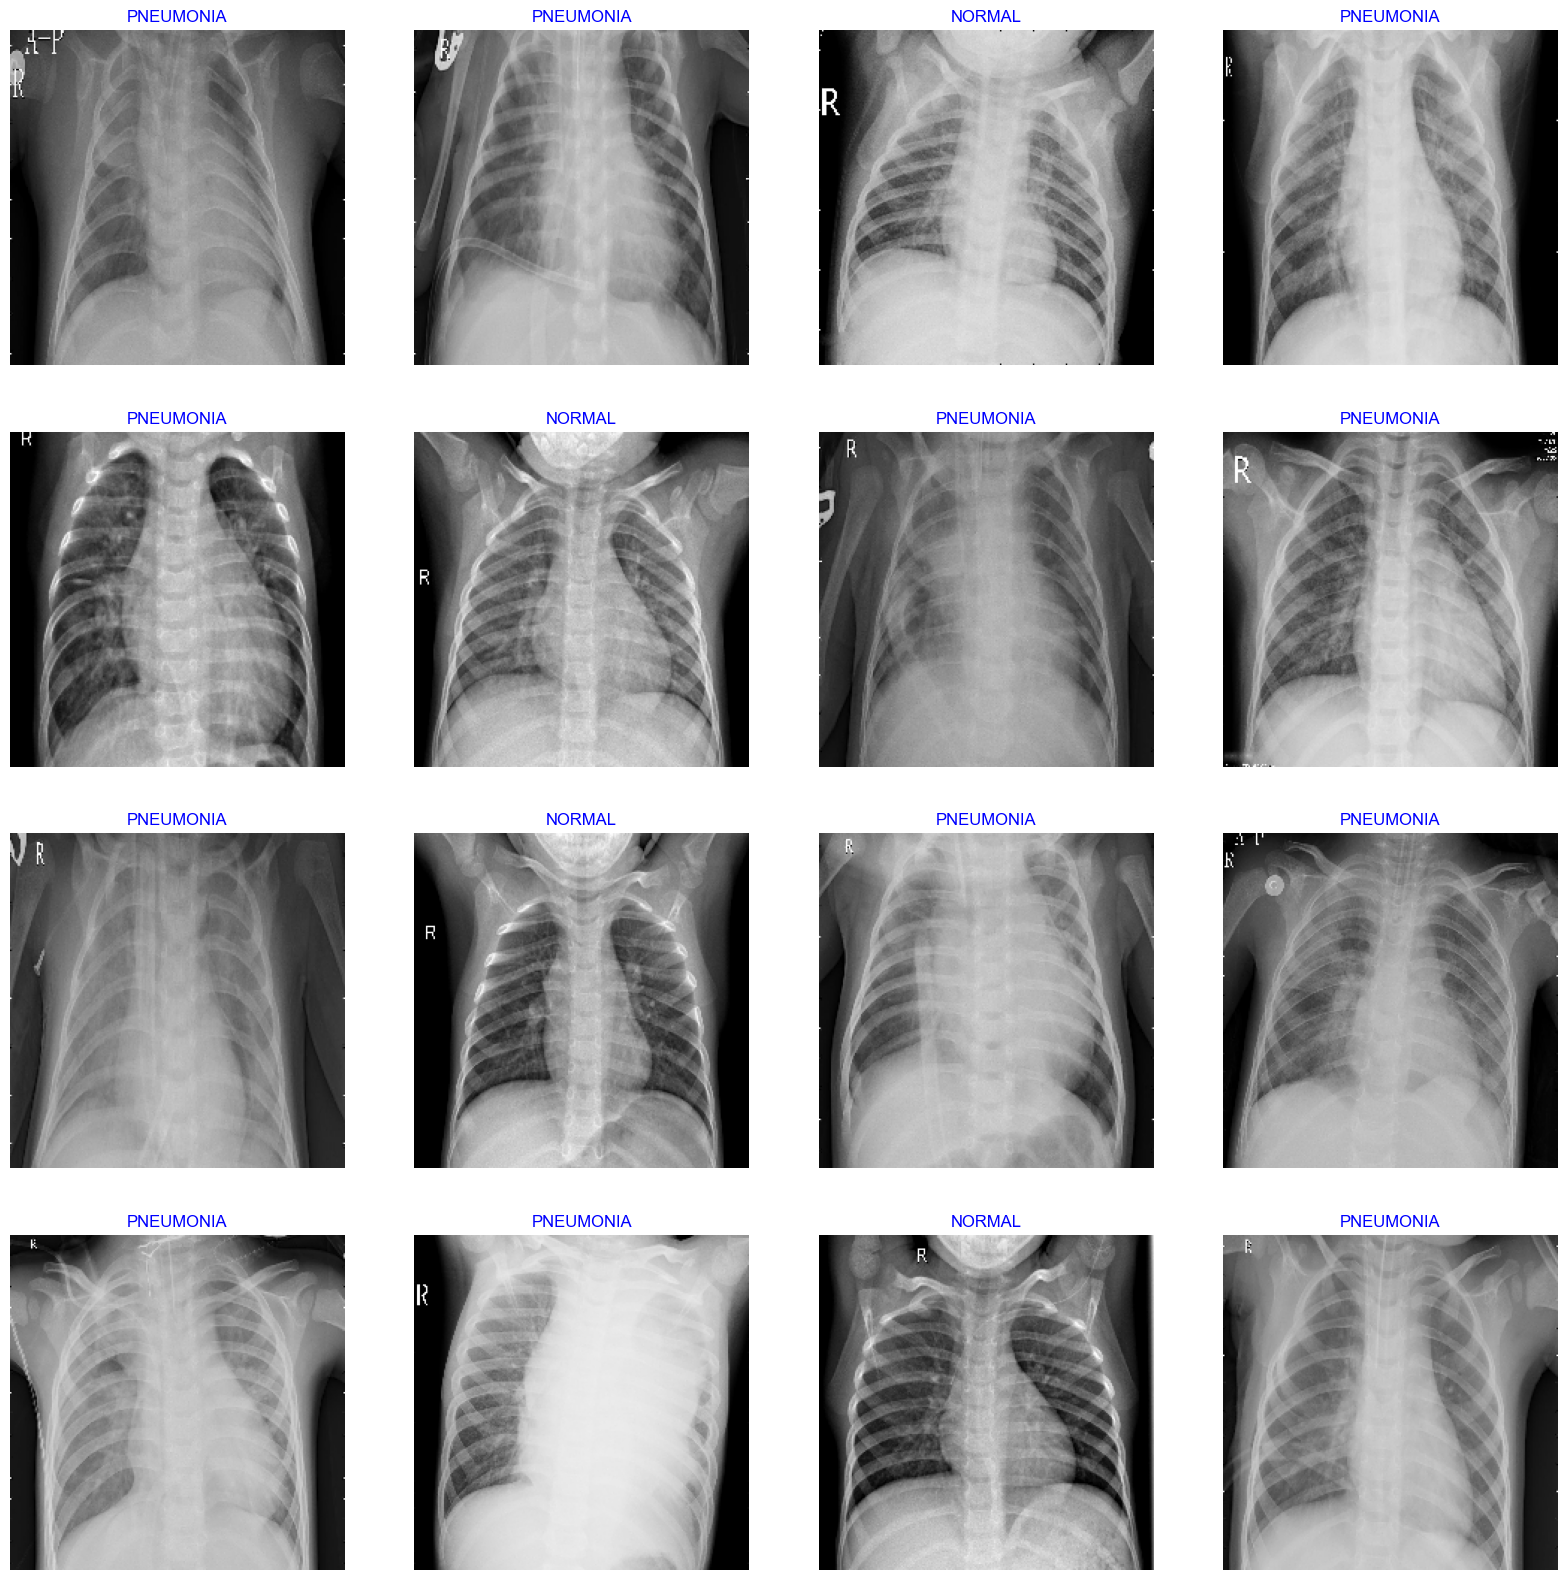

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## **Model Structure**

In [12]:
img_size = (224, 224)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet',input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])
model.compile(Adamax(learning_rate = 0.0001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11183665 (42.66 MB)
Trainable params: 1109

## **Model Training**

In [13]:
# METODO 1
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.compat.v1.Session(config=config)

# METODO 2
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
#session = tf.compat.v1.Session(config=config)

Epochs = 5
history = model.fit(x= train_gen, epochs = Epochs, verbose = 1, batch_size = 16, validation_data = valid_gen, validation_steps = None, shuffle = False)

Epoch 1/10
262/262 [==============================] - 814s 3s/step - loss: 7.9150 - accuracy: 0.7871 - val_loss: 7.2462 - val_accuracy: 0.9108
Epoch 2/10
262/262 [==============================] - 781s 3s/step - loss: 6.7805 - accuracy: 0.9219 - val_loss: 6.4959 - val_accuracy: 0.9140
Epoch 3/10
262/262 [==============================] - 796s 3s/step - loss: 6.0133 - accuracy: 0.9376 - val_loss: 5.6220 - val_accuracy: 0.9713
Epoch 4/10
262/262 [==============================] - 771s 3s/step - loss: 5.3346 - accuracy: 0.9517 - val_loss: 5.0163 - val_accuracy: 0.9761
Epoch 5/10
262/262 [==============================] - 792s 3s/step - loss: 4.8042 - accuracy: 0.9618 - val_loss: 4.5654 - val_accuracy: 0.9793
Epoch 6/10
262/262 [==============================] - 778s 3s/step - loss: 4.3984 - accuracy: 0.9637 - val_loss: 4.1876 - val_accuracy: 0.9825
Epoch 7/10
262/262 [==============================] - 767s 3s/step - loss: 4.0628 - accuracy: 0.9711 - val_loss: 3.8745 - val_accuracy: 0.9889

## **Evaluation**

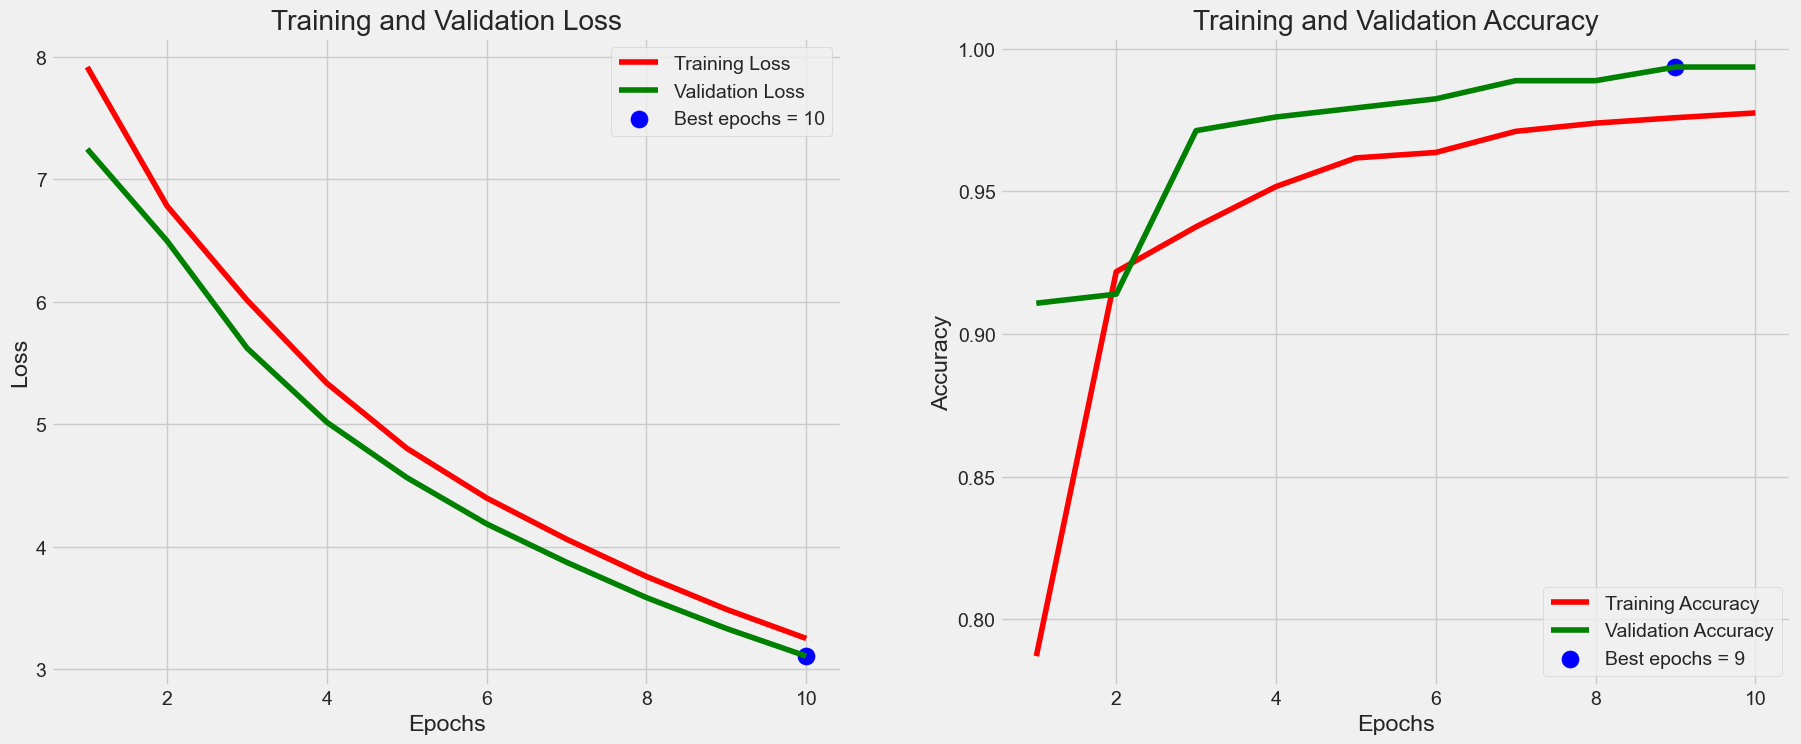

In [19]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [15]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 11s 660ms/step - loss: 3.1078 - accuracy: 0.9961
Train Loss:  3.0835540294647217
Train Accuracy:  1.0
--------------------
Validation Loss:  3.104635715484619
Validation Accuracy:  0.99609375
--------------------
Test Loss:  3.1077911853790283
Test Accuracy:  0.99609375


## **Predictions**

In [16]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

## **Confusion matrix and Classification report**

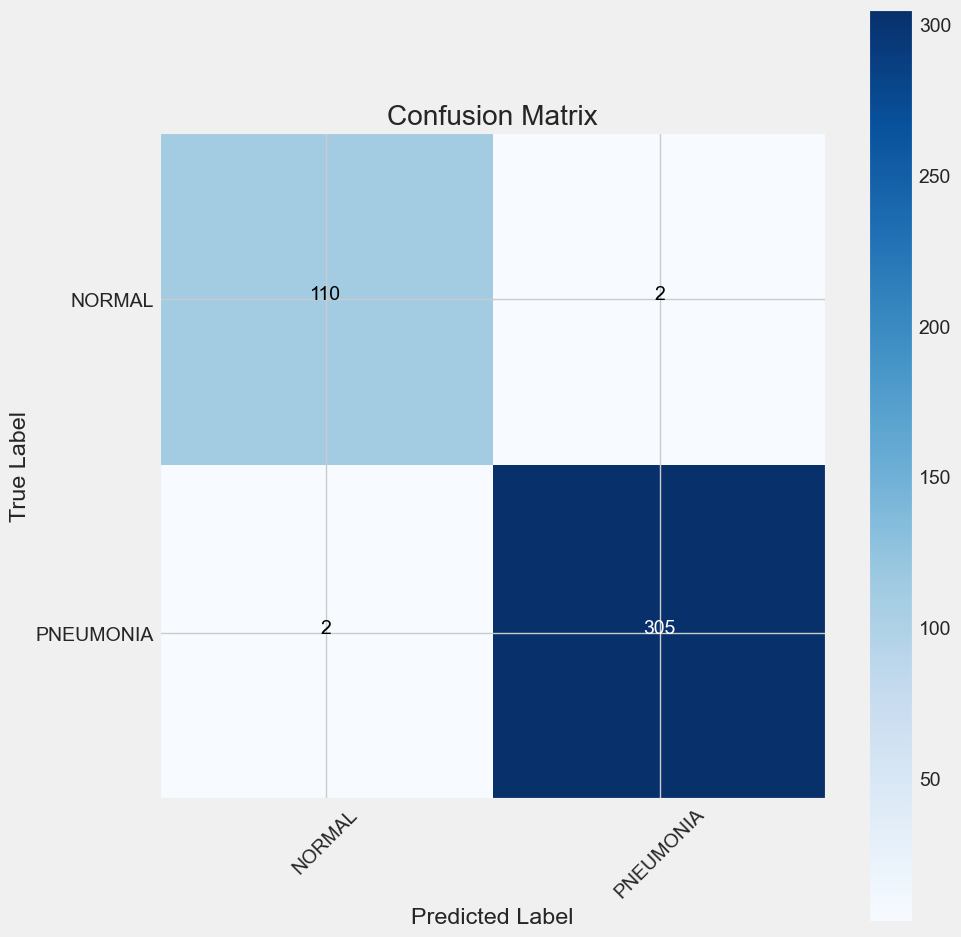

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [18]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      NORMAL       0.98      0.98      0.98       112
   PNEUMONIA       0.99      0.99      0.99       307

    accuracy                           0.99       419
   macro avg       0.99      0.99      0.99       419
weighted avg       0.99      0.99      0.99       419



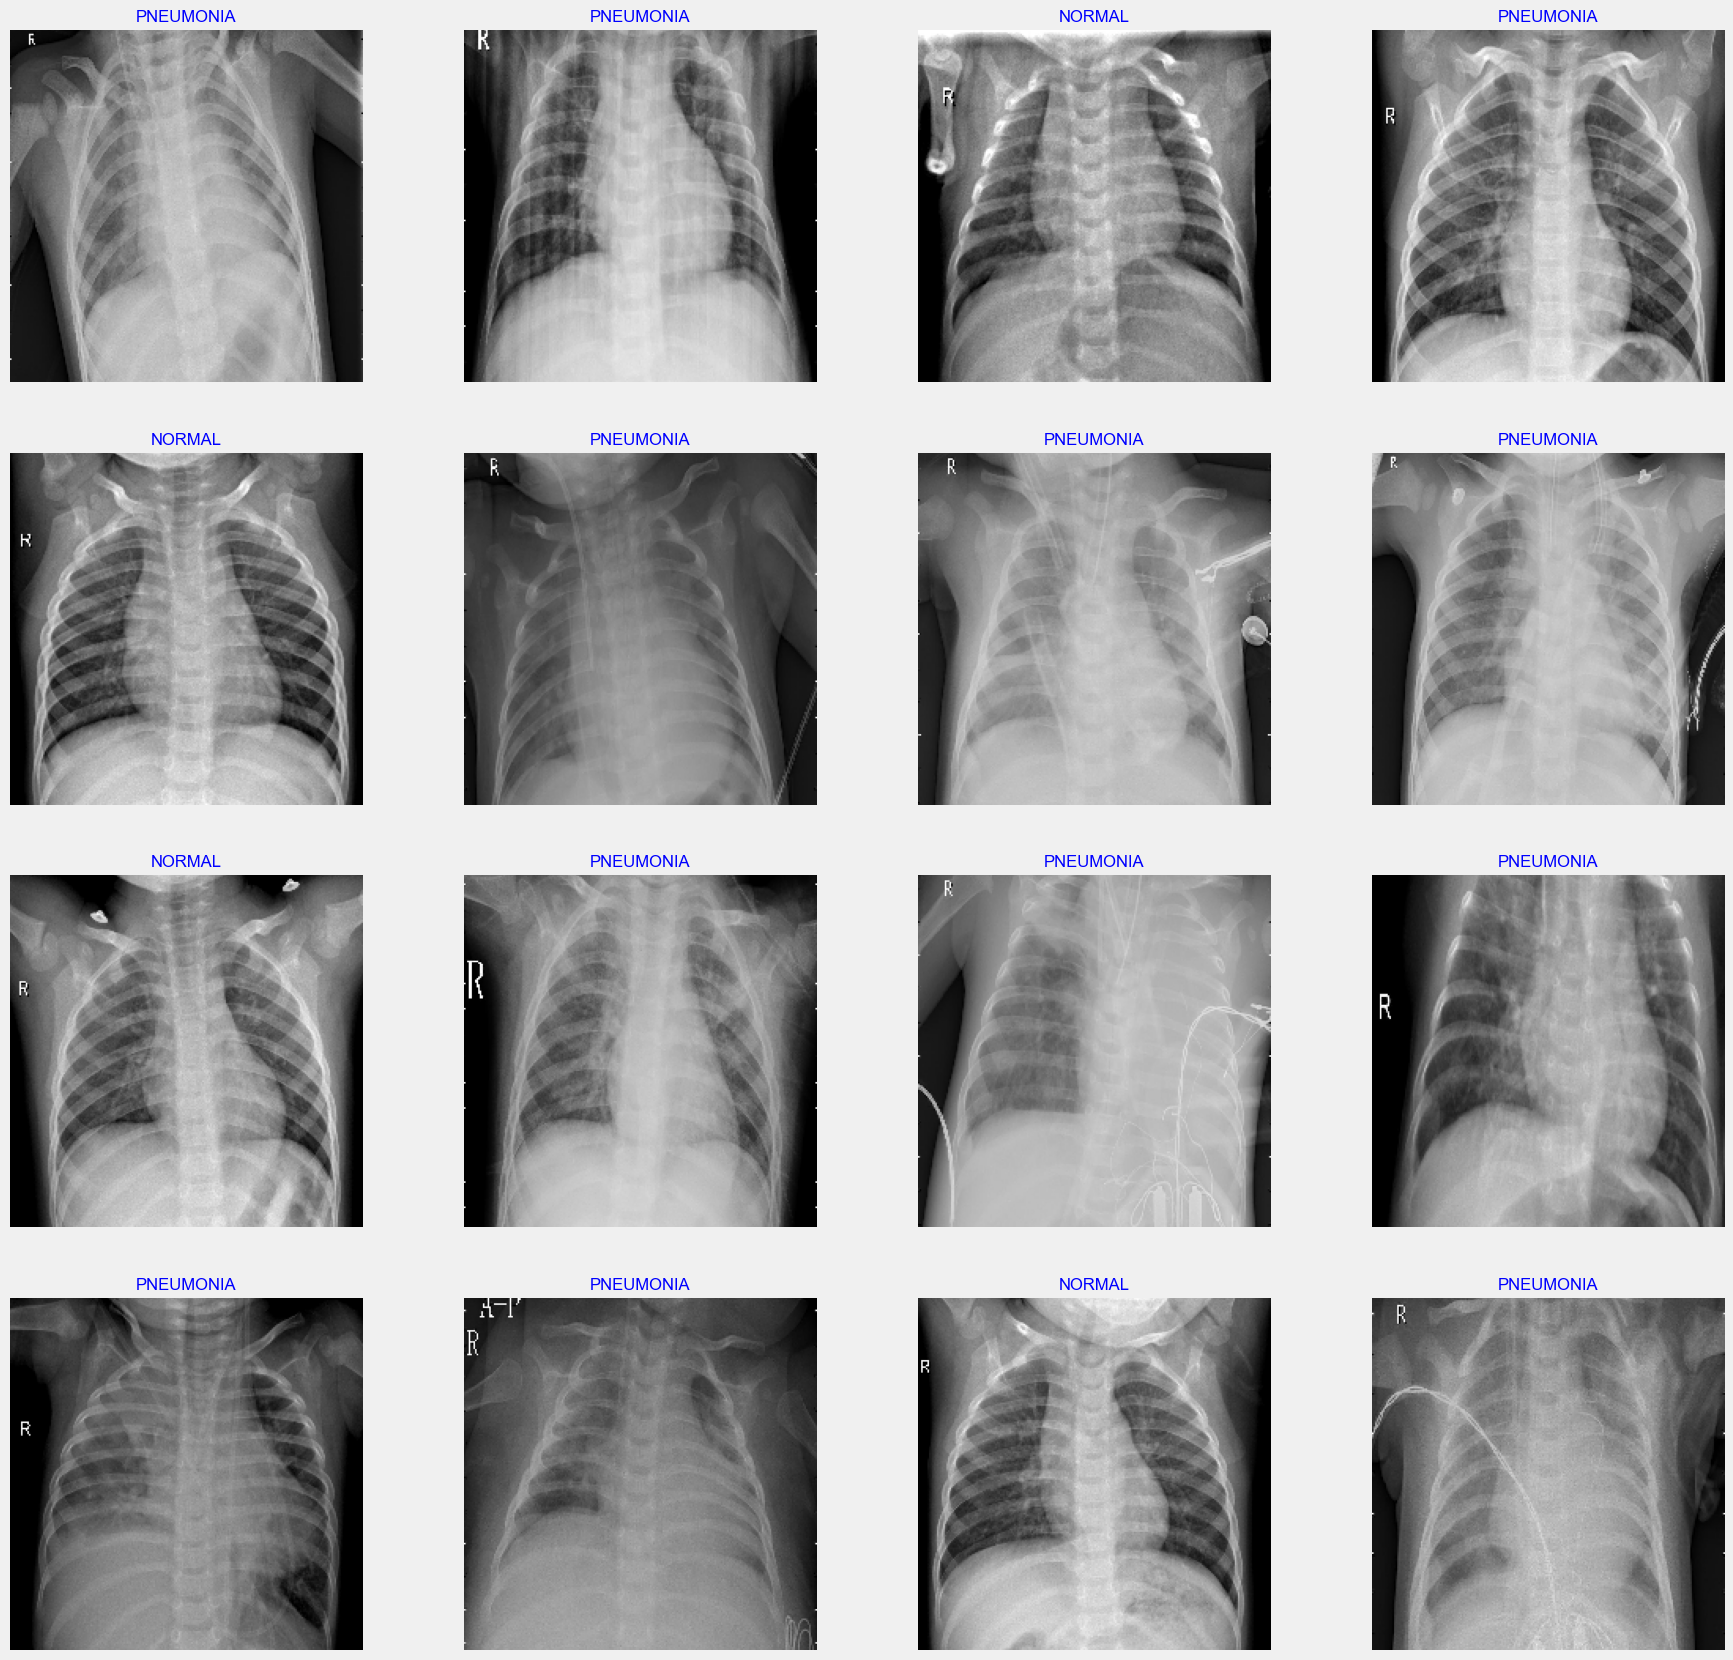

In [21]:
gen_dict = valid_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(valid_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();